<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/feedback_prize_v3_ulmfit_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

In [2]:
import os
from pathlib import Path
import fastai
fastai.__version__

'2.7.9'

In [3]:
# config depending on whether this is running on kaggle or collab
# is_colab = True
is_colab = not os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
comp = 'feedback-prize-english-language-learning'
if is_colab:
    model_save_path = Path('/content/'+comp+'_out/models')
else:
    model_save_path = Path('/kaggle/working/'+comp) #+'/models')

In [4]:
# import colab libraries
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
if is_colab:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# This permissions change avoids a warning on Kaggle tool startup.
if is_colab:
    !chmod 600 ~/.kaggle/kaggle.json

In [7]:
path = setup_comp(comp)
path

100%|██████████| 2.80M/2.80M [00:00<00:00, 202MB/s]

Path('feedback-prize-english-language-learning')

In [8]:
from fastai.text.all import *
set_seed(32)

### Language model for original text

In [9]:
# read train csv
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and st...",3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A\n\nproblem is a change for you because it can make you see different and help you to understand how tings wok.\n\nFirst of all it can make you see different then the others. For example i remember that when i came to the United States i think that nothing was going to change me because i think that nothing was going to change me bec...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school policy of having a grade b average that unfair. Because many students have a C average. So that means that they cant go out for sports or other activities they want to do bad. That's like taking everything they have. What if kids want to become good at something, but now they cant because of that school policy. If they have a C average they should still be able to go out for sports or activities. A C average isn't that bad, its higher then a D average. If the school police was if you have a D average of lower they shouldn't do sports or activities....",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,"The best time in life is when you become yourself. I agree that the greatest accomplishment, is when you be yourself in a world that constantly trying to make you something else. Because you make your own choices, you become more happy, and you respect others.\n\nFirst, you make your own choices by being yourself. Becoming yourself means that you should be able to make your own choices and not be shy or afraid of what you're doing. Because you're defining yourself by doing those things that you want. Some people follow others, therefore, they don't make their own choices. People are afraid...",4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other people can change people to become better persons you can have an impact of kindess with a homeles that can change his life or with some who needed they are going to know you are a nice person if you are a nice person everywhere you go people is going to like your personality so you have to be a nice person with others like a old women triying to cross the road thats a impact of kindness when you do that you feel a greate person you can change people in the way they think by helping others treating nice other people give them some advice when you s...,2.5,3.0,3.0,3.0,2.5,2.5


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [11]:
# random sampling to test in collab
if is_colab: train_df = train_df.sample(frac=0.10)
train_df.shape[0]

391

In [12]:
# # In this cell fastai TextDataLoader functions are overridden to allow taking output 
# # directory as input so that the toknised data is not written in data input directory
# # in Kaggle, data input directory is read-only
# from fastai.text.core import _tokenize_files
# @delegates(_tokenize_files)
# def tokenize_folderOP(path, extensions=None, folders=None,
#                       output_dir=None, skip_if_exists=True, **kwargs):
#     """replacement of fastai.text.core.tokenize_folder so that it passes
#      output_dir as input to _tokenize_files"""
#     path,extensions = Path(path),ifnone(extensions, ['.txt'])
#     files = get_files(path, extensions=extensions, recurse=True, folders=folders)
#     def _f(i,output_dir): return output_dir/files[i].relative_to(path)
#     return _tokenize_files(_f, files, path, output_dir, 
#                            skip_if_exists=skip_if_exists, **kwargs)

# class TokenizerOP(Tokenizer):
#     """Wrapper class for fastai.text.core.Tokenizer class to override
#     from_folder method to take output_dir as input and call the overridden
#     method tokenize_folderOP"""
#     def __init__(self, tok, rules=None, counter=None,
#                  lengths=None, mode=None, sep=' '):
#         super().__init__(tok, rules=rules, counter=counter,
#                  lengths=lengths, mode=mode, sep=sep)
    
#     @classmethod
#     @delegates(tokenize_folderOP, keep=True)
#     def from_folder(cls, path, tok=None, rules=None, output_dir = None, **kwargs):
#         path = Path(path)
#         if tok is None: tok = WordTokenizer()
#         output_dir = tokenize_folderOP(path, tok=tok, rules=rules, 
#                                        skip_if_exists = False, 
#                                        output_dir = output_dir, **kwargs)
#         res = cls(tok, counter=load_pickle(output_dir/fn_counter_pkl),
#                   lengths=load_pickle(output_dir/fn_lengths_pkl),
#                   rules=rules, mode='folder')
#         res.path,res.output_dir = path,output_dir
#         return res


# class TextBlockOP(TextBlock):
#     "Overriding TextBlock for user defined output dir"
#     def __init__(self, tok_tfm, vocab=None, is_lm=False,
#                  seq_len=72, backwards=False, **kwargs):
#         super().__init__(tok_tfm, vocab=vocab, is_lm=is_lm,
#                  seq_len=seq_len, backwards=backwards, **kwargs)
#     @classmethod
#     @delegates(TokenizerOP.from_folder, keep=True)
#     def from_folder(cls, path, vocab=None, is_lm=False, seq_len=72,
#                     backwards=False, min_freq=3, max_vocab=60000,output_dir =None,
#                     **kwargs):
#         "Build a `TextBlock` from a `path` - calls TokenizerOP and provides output_dir as input"
#         return cls(TokenizerOP.from_folder(path, output_dir = output_dir, **kwargs), vocab=vocab, is_lm=is_lm, seq_len=seq_len,
#                    backwards=backwards, min_freq=min_freq, max_vocab=max_vocab)
        
# class TextDataLoadersOP(TextDataLoaders):
#     "Basic wrapper around several `DataLoader`s with factory methods for NLP problems"
#     @classmethod
#     @delegates(DataLoaders.from_dblock)
#     def from_folder(cls, path, train='train', valid='valid', valid_pct=None,
#                     seed=None, vocab=None, text_vocab=None, is_lm=False,
#                     tok_tfm=None, seq_len=72, splitter=None,
#                     backwards=False, output_dir =None, **kwargs):
#         "This is to override same method from TextDataLoaders to accept and pass output_dir as input"
#         if splitter is None:
#             splitter = GrandparentSplitter(train_name=train,
#                                            valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct,
#                                                                                                       seed=seed)
#         blocks = [TextBlockOP.from_folder(path, text_vocab, is_lm, seq_len, backwards,
#                                           tok=tok_tfm, output_dir = output_dir)]
#         if not is_lm: blocks.append(CategoryBlock(vocab=vocab))
#         get_items = partial(get_text_files, folders=[train,valid]) if valid_pct is None else get_text_files
#         dblock = DataBlock(blocks=blocks,
#                            get_items=get_items,
#                            splitter=splitter,
#                            get_y=None if is_lm else parent_label)
#         return cls.from_dblock(dblock, path, path=path, seq_len=seq_len, **kwargs)

#     @classmethod
#     @delegates(DataLoaders.from_dblock)
#     def from_df(cls, df, path='.', valid_pct=0.2, seed=None, text_col=0, label_col=1, label_delim=None, y_block=None,
#                 text_vocab=None, is_lm=False, valid_col=None, tok_tfm=None, tok_text_col="text", seq_len=72, backwards=False, **kwargs):
#         "Create from `df` in `path` with `valid_pct`"
#         blocks = [TextBlock.from_df(text_col, text_vocab, is_lm, seq_len, backwards, tok=tok_tfm)]
#         if y_block is None and not is_lm:
#             blocks.append(MultiCategoryBlock if is_listy(label_col) and len(label_col) > 1 else CategoryBlock)
#         if y_block is not None and not is_lm: blocks += (y_block if is_listy(y_block) else [y_block])
#         splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
#         dblock = DataBlock(blocks=blocks,
#                            get_x=ColReader(tok_text_col),
#                            get_y=None if is_lm else ColReader(label_col, label_delim=label_delim),
#                            splitter=splitter)
#         return cls.from_dblock(dblock, df, path=path, seq_len=seq_len, **kwargs)

### Language model finetuning

In [13]:
# tok_path = model_save_path / 'train_tok'
# tok_path.mkdir(parents=True, exist_ok=True)
dls_lm = TextDataLoaders.from_df(train_df, text_col='full_text', is_lm=True,
                                       valid_pct=0.1,)
                                #   output_dir = tok_path)
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos i disagree whit this statement , because positive attitude is not the solution for all your problems in life there are many problem that you can beat . \n\n when you came to this country and you are alone and do nt have help from other people you just ca nt be positive you do nt understand the language and if you are illegal you do nt have the many benefit","i disagree whit this statement , because positive attitude is not the solution for all your problems in life there are many problem that you can beat . \n\n when you came to this country and you are alone and do nt have help from other people you just ca nt be positive you do nt understand the language and if you are illegal you do nt have the many benefit like"
1,7 steps from the half court of the basketball court . xxmaj you are the most fastest person in the world . xxmaj you would be faster then everyone in the whole school and the most fastest in the track team and could also go to the xxunk . xxmaj find out your best skill and what your good at . \n\n xxmaj you can do what many people ca nt do,steps from the half court of the basketball court . xxmaj you are the most fastest person in the world . xxmaj you would be faster then everyone in the whole school and the most fastest in the track team and could also go to the xxunk . xxmaj find out your best skill and what your good at . \n\n xxmaj you can do what many people ca nt do in
2,your head which would give you another xxunk . xxmaj now with a student that is in online classes wo n't have to worry about those xxunk . \n\n xxmaj even the simple things could affect your ability to be able to learn like what you eat . xxmaj if you do nt eat anything during the day you get hungry and that becomes a xxunk . xxmaj in most schools they,head which would give you another xxunk . xxmaj now with a student that is in online classes wo n't have to worry about those xxunk . \n\n xxmaj even the simple things could affect your ability to be able to learn like what you eat . xxmaj if you do nt eat anything during the day you get hungry and that becomes a xxunk . xxmaj in most schools they serve
3,"i can be better tomorrow . xxbos xxmaj imagine running through the xxunk so fast with something under your feet running by people kicking is as hard as you can for your team to be in the lead . xxmaj just imagine doing something you love that makes you xxunk and it just feels like you have never worked a day in your life , my three major reasons are improve ,","can be better tomorrow . xxbos xxmaj imagine running through the xxunk so fast with something under your feet running by people kicking is as hard as you can for your team to be in the lead . xxmaj just imagine doing something you love that makes you xxunk and it just feels like you have never worked a day in your life , my three major reasons are improve , have"
4,belive that if student 's can find a goal of having to be going for 3 years in school instead of 4 year 's . it would take them hard work and confident in order to earn it but other 's might say that they xxunk to be in school longer . because of friend 's or liking to learn alot and it no rush toward them for they are xxunk in,that if student 's can find a goal of having to be going for 3 years in school instead of 4 year 's . it would take them hard work and confident in order to earn it but other 's might say that they xxunk to be in school longer . because of friend 's or liking to learn alot and it no rush toward them for they are xxunk in learning


In [15]:
# dump vocab that will be required for inference script
model_save_path.mkdir(parents=True, exist_ok=True)
with open(model_save_path / 'dls_lm_vocab.pickle', 'wb') as b:
    pickle.dump(dls_lm.vocab,b)

In [16]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [17]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.349894,4.008068,0.237728,55.040436,00:07


In [18]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.052726,3.923204,0.244792,50.562172,00:07
1,3.942304,3.793540,0.254385,44.413326,00:07
2,3.797738,3.722722,0.259749,41.376881,00:07
3,3.653148,3.684710,0.265330,39.833569,00:08
4,3.516006,3.681235,0.267437,39.695381,00:08
5,3.400863,3.671598,0.269528,39.314671,00:07
6,3.294753,3.676487,0.269636,39.507378,00:07
7,3.208072,3.672323,0.271846,39.343204,00:07
8,3.149429,3.679417,0.270789,39.623272,00:07
9,3.111506,3.679897,0.270646,39.642303,00:07


In [19]:
model_save_path.mkdir(parents=True, exist_ok=True)
if iskaggle:
    # hack to save encoder in a writable location
    learn_lm.path = model_save_path
    learn_lm.save_encoder('finetuned_enc')
    # learn_lm.save('finetuned_lm')
else:
    learn_lm.save_encoder(model_save_path / 'finetuned_enc')

Classification model finetuning

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 2135 to 2032
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      391 non-null    object 
 1   full_text    391 non-null    object 
 2   cohesion     391 non-null    float64
 3   syntax       391 non-null    float64
 4   vocabulary   391 non-null    float64
 5   phraseology  391 non-null    float64
 6   grammar      391 non-null    float64
 7   conventions  391 non-null    float64
dtypes: float64(6), object(2)
memory usage: 27.5+ KB


In [21]:
dls = DataBlock(
    blocks=(TextBlock.from_df('full_text', vocab = dls_lm.vocab),
            RegressionBlock,
            RegressionBlock,
            RegressionBlock,
            RegressionBlock,
            RegressionBlock,
            RegressionBlock),
    n_inp=1,
    get_x=ColReader('text'), 
    get_y=[ColReader('cohesion'), 
           ColReader('syntax'),
           ColReader('vocabulary'),
           ColReader('phraseology'),
           ColReader('grammar'), 
           ColReader('conventions')],
    splitter=RandomSplitter(0.2, seed=42),

).dataloaders(train_df, bs=64)
dls.show_batch()

,text,text_,text__,text___,text____,text_____,text______
0,"xxbos xxmaj it 's a good idea for students to graduate of three years of high school instead of taking for years , i think if they have already passed their classes then they would not have to take elective classes and they might be able to graduate early , but if they need more then seven classes then they might do not be able to graduate and they will have to come during summer to complete their classes that they need to pass . \n\n xxmaj for example if they are still missing some of the work they had to complete at the end of the year they would have to come during summer school or maybe take more classes then what they were allow to be taking . \n\n xxmaj if they need to complete more work they might come during summer break , i think it would",3.5,4.0,3.0,4.0,3.0,3.0
1,"xxbos xxmaj have you ever accomplished something in your life ? xxmaj because people nowadays are very lazy and hard headed because they are easily distracted by social media , people around them , and also the society that 's why they can not focus on their goals in life . xxmaj although some might argue it is not better to work on something to accomplish , actually it is better to work on something to accomplish because you will gain more knowledge and people will be proud to what you 've accomplished . \n\n xxmaj one reason why it is better to work on something to accomplish is because you will gain more knowledge . xxmaj for instance , based on my personal experience when i was in middle school , i do nt do my projects , homework , xxunk works because xxmaj i 'm too lazy and",4.0,4.0,4.0,4.0,3.5,3.5
2,"xxbos i agree with success consists of going from failure to failure without loss of enthusiasm because everyone need to be stronger , successful , and become independent xxunk . \n\n xxmaj success are things that everybody need to be stronger the most they can with every single thing in your life because everyone has bad moments in lifes and there are many peoples that they want to see them fail in everything . xxmaj for example , if someone is given in they can find someone who is bad person and the only thing that they do is to given words that did not help in anything , but that 's why they have to failure , but do not have to loss enthusiasm because if you loss enthusiasm you are failed in everything because in lifes you can find peoples that want to help you a lot ,",3.0,2.5,3.0,2.5,2.5,3.5
3,"xxbos xxmaj today world , everything start to moving forward . xxmaj people start to invent the new ideas and those ideas make life more easily . xxmaj in medical world , people make a new kind of medicine to xxunk the xxunk , compare to the old world a lot of people had die . xxmaj in technology world , people put those ideas into the physical xxunk that it is so important for today life . xxmaj from all we see everything is start from the ideas and who invent the idea ? xxmaj this is the kind of the question that no one ever ask . xxmaj it is us the people that invent the idea . \n\n xxmaj people can make a change to the world if they start to think or we can call the attitude . xxmaj the attitude of the people have a",4.0,4.0,3.5,3.5,3.5,4.0
4,"xxbos "" getting something by doing something or doing nothing also bring us something "" \n\n xxmaj we accomplish more if we are always doing something , because if we do more than what we want or have we will always be growing , everytime that we do something no matter what it 's we receive something back , many people called '' reward "" , when we want something and we work hard to get that , we create a confidence in ourself 's that we now that by doing something we can get what we want and we motivate ourself to accomplish that . we get more if we do more , but some people think that by doing nothing you can get something back . accomplishment is something that you get by working hard , giving your best , and by doing something about it , if",3.5,3.5,4

In [22]:
reg_loss = MSELossFlat()
def cohesion_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,0],cohesion)
def cohesion_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,0],cohesion))

def syntax_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,1],syntax)
def syntax_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,1],syntax))

def vocabulary_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,2],vocabulary)
def vocabulary_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,2],vocabulary))

def phraseology_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,3],phraseology)
def phraseology_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,3],phraseology))

def grammar_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,4],grammar)
def grammar_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,4],grammar))

def conventions_err(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return reg_loss(inp[:,5],conventions)
def conventions_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return torch.sqrt(reg_loss(inp[:,5],conventions))



In [23]:
# combine all loss and error metrics
def combine_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions): 
    return (cohesion_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions) + \
        syntax_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions)+ \
        vocabulary_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions)+ \
        phraseology_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions)+ \
        grammar_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions)+ \
        conventions_loss(inp,cohesion,syntax,vocabulary,phraseology,grammar,conventions)) / 6

err_metrics = (cohesion_err,syntax_err, vocabulary_err,
               phraseology_err, grammar_err, conventions_err)



In [24]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                backwards=False,
                                y_range = (0, 5.5),
                                loss_func=combine_loss,
                                metrics=err_metrics,
                                n_out=6
                                # metrics=[accuracy,F1Score(average='weighted')]
                                ).to_fp16()
# load encoder from language model
if iskaggle: model_save_path = model_save_path / 'models'
learn = learn.load_encoder(model_save_path / 'finetuned_enc')

In [25]:
# learn.loss_func

SuggestedLRs(valley=0.001737800776027143, slide=0.013182567432522774)

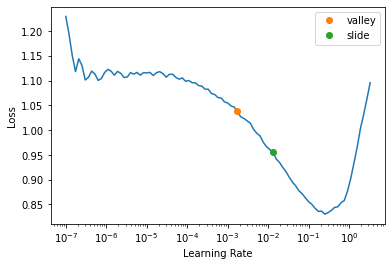

In [26]:
learn.lr_find(suggest_funcs=(valley, slide))

In [27]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,cohesion_err,syntax_err,vocabulary_err,phraseology_err,grammar_err,conventions_err,time
0,1.087521,0.691545,0.488515,0.372705,0.352312,0.564675,0.726824,0.428725,00:02


epoch,train_loss,valid_loss,cohesion_err,syntax_err,vocabulary_err,phraseology_err,grammar_err,conventions_err,time
0,0.839373,0.698345,0.402962,0.355585,0.503980,0.523013,0.685572,0.514269,00:05
1,0.789064,0.711095,0.471242,0.317883,0.582807,0.612032,0.617092,0.509908,00:05
2,0.739339,0.663551,0.380531,0.325583,0.432241,0.458488,0.635443,0.462404,00:05
3,0.693330,0.680785,0.421837,0.323539,0.435153,0.477437,0.661390,0.515542,00:05
4,0.663573,0.677220,0.426548,0.313508,0.438774,0.463231,0.660003,0.502943,00:05


In [28]:
model_save_path.mkdir(parents=True, exist_ok=True)
# learn.export(f'{model_save_path}/all_col_concat_learner.pkl')
learn.save(f'{model_save_path}/ulmfit_baseline_save.pkl')

Path('/content/feedback-prize-english-language-learning_out/models/ulmfit_baseline_save.pkl.pth')

### Test data

In [29]:
test_df = pd.read_csv(path / 'test.csv')
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their is always going to be good people to help you and try to explane the job you need to get done in life you were not born with knowing everything. Life is bassicly about learing new things every single day even though without experience because life is simple and we must live happy and around with the people we love. When a person thinks they know everything in life they dont do good because they trying to make the other person less then others you must be kind to those the dont have experience because you may not know some day you will go to a ...
1,000BAD50D026,"Do you think students would benefit from being able attend classes from home?\n\nYes! its benefit for student who attend classes from home. Because some student want to attend classes from home because they thinks it's very important for them . And they think they can learned fast, and understand than they student who attend classes from school. For example my friend told me that she's attand classes from home it's good for her, because they is some subject she didn't understand when she attend classes from school but when she attend the home classes she good for that subject. she like sci..."
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonderful how much we can get done when we are always doing something,I agree to this statement. Some people say that it is always better to always be doing something than to be inactive and so nothing at all to chase after on your dreams. always doing something lets you feel a sense of accomplishment,it makes you want to strive to do even more than what you did,you can also learn something along the way.\n\nThe first reason that always doing is better than doing nothing is that it gives you a sense of you accomplishing something. when you finish a ..."


In [30]:
test_df.rename(columns = {'full_text':'text'}, inplace = True)
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,xxbos when a person has no experience on a job their is always going to be good people to help you and try to xxunk the job you need to get done in life you were not born with knowing everything . xxmaj life is xxunk about xxunk new things every single day even though without experience because life is simple and we must live happy and around with the people we love . xxmaj when a person thinks they know everything in life they do nt do good because they trying to make the other person less then others you must be kind to those the do nt have experience because you may not know some day you will go to a different country . xxmaj when you do nt know xxunk because you not from their so you going to need help from others to explain you about
1,"xxbos xxmaj thomas xxmaj jefferson once states that "" it is wonderful how much we can get done when we are always doing something , i agree to this statement . xxmaj some people say that it is always better to always be doing something than to be inactive and so nothing at all to chase after on your dreams . always doing something lets you feel a sense of accomplishment , it makes you want to xxunk to do even more than what you did , you can also learn something along the way . \n\n xxmaj the first reason that always doing is better than doing nothing is that it gives you a sense of you accomplishing something . when you finish a task you feel successful with yourself in saying that you xxunk something and kept going . for example , when you graduate from school and"
2,"xxbos xxmaj do you think students would benefit from being able attend classes from home ? \n\n xxmaj yes ! its benefit for student who attend classes from home . xxmaj because some student want to attend classes from home because they thinks it 's very important for them . xxmaj and they think they can learned fast , and understand than they student who attend classes from school . xxmaj for example my friend told me that she 's xxunk classes from home it 's good for her , because they is some subject she did n't understand when she attend classes from school but when she attend the home classes she good for that subject . she like science she think science its important for her but she did n't understand anything any science but she understand science because she attend classes from home . xxmaj and some"


In [31]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[2.8516, 3.0000, 2.8379, 3.1230, 2.7227, 2.8906],
        [2.3730, 2.6406, 2.3242, 2.7949, 2.2793, 2.6387],
        [3.1152, 3.1152, 2.9414, 2.7949, 2.7305, 3.0527]])

In [32]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = ['cohesion','syntax','vocabulary',
                                                 'phraseology','grammar','conventions'])
probs_df

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.851562,3.000000,2.837891,3.123047,2.722656,2.890625
1,2.373047,2.640625,2.324219,2.794922,2.279297,2.638672
2,3.115234,3.115234,2.941406,2.794922,2.730469,3.052734


In [33]:
probs_df["text_id"] = test_df["text_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_id
2.8515625,3.0,2.8378906,3.1230469,2.7226562,2.890625,0000C359D63E
2.3730469,2.640625,2.3242188,2.7949219,2.2792969,2.6386719,000BAD50D026
3.1152344,3.1152344,2.9414062,2.7949219,2.7304688,3.0527344,00367BB2546B


In [34]:
if not iskaggle:
    push_notebook('saan', comp,
                  title='Feedback Prize lang learn: ulmfit baseline',
                  file='/content/drive/MyDrive/Colab Notebooks/feedback_prize_v3_ulmfit_baseline.ipynb',
                  competition=comp, private=False, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/saansd2003/feedback-prize-lang-learn-ulmfit-baseline
